# Task 3
## Particles filter
### Robot description

A mobile robot is located in a square area 1000 meters long. Radio beacons are installed in the corners of the area. The robot can measure the distance to beacons. The measurement error is described by a normal distribution with zero mean and standard deviation $\sigma = 15$. It is known that the initial position of the robot is in the range of coordinates (0-100, 0-100). The initial orientation of the robot is $0 \pm 2$ degrees.

The robot functions as follows:

- Accepts from the operator the required angle of rotation and range of movement;
- Rotates to a given angle;
- Moves for a given distance;
- Measures the distance to beacons;
- Calculates position.

The robot rotates through a given angle with a normally distributed error with zero mean and standard deviation $\sigma_{\theta} = 2$. The robot moves to a given distance with a normally distributed error with zero mean and standard deviation $\sigma_{l} = 15$. It is required to build a particle filter to improve the localization accuracy of the robot.

### Task

- Set the initial position of the robot and standard deviations;
- Set at least 5 commands to move the robot;
- Build the trajectory of the robot's movement, taking into account errors;
- Build a particle filter for the robot;
- Build a trajectory of the robot's movement, the position of the particles and an estimate of the position of the robot after the execution of each of the commands;
- Repeat the previous steps for three different initial positions, standard deviations, number of particles and motion paths.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

class robot:
    counter = 0
    s_measure = 15
    s_move = 15
    s_rot = 2
    id_true = 0

    def __init__(self,angle = 0, pos = None, N = 0, length = 1000, sigma = 3, real = False):
        if pos is None:
            self.pos = np.array([0,0])
        else:
            self.pos = pos

        self.angle = angle
        #initializing robot id
        self.id = robot.counter
        robot.counter+=1
        self.real = real
        
        self.coord = [[self.pos[0]], [self.pos[1]]]
        self.measures = [[],[]]
        self.th = [self.angle]
        self.weight = 0       
        
    def copy(self):
        return robot(angle = self.angle, pos = self.pos)

    def get(self):
        return self.pos
    def noise(self, s):
        return np.random.normal(0,s)
    
    def update_coord(self, lst, pos):
        lst[0].append(pos[0])
        lst[1].append(pos[1])
        
    def move(self, u):
            angle = np.deg2rad(self.angle)
            if self.real == True:
                u_noised = u
            else:
                u_noised = u+ self.noise(robot.s_move)
            x_noised = u_noised*np.cos(angle)
            y_noised = u_noised*np.sin(angle)
            pose_noised = np.array([x_noised, y_noised])
            self.pos = self.pos+ pose_noised
            self.update_coord(self.coord, self.pos)

    def measure(self):
        if self.real == True:
            noise = np.array([self.noise(robot.s_measure),self.noise(robot.s_measure)])
            pos = self.pos + noise
            self.update_coord(self.measures, pos)
            return pos

    def rot(self, ang):
        if self.real == True:
            self.angle = self.angle+ ang
        else:
            self.angle = self.angle+ ang+ self.noise(self.s_rot)
        self.th.append(self.angle)

    def __prob(self, dist, meas_dist):
        d = np.sqrt(dist[0]**2+dist[1]**2)
        m = np.sqrt(meas_dist[0]**2+ meas_dist[1]**2)
        sig = 1
        #return 1/(2 * np.pi * robot.s_measure) *np.exp(-((d-m)**2 / (2.0 * robot.s_measure**2)))
        return 1/(2 * np.pi * sig) * np.exp( -((dist[0] - meas_dist[0])**2 / sig**2 +(dist[1] - meas_dist[1])**2 / sig**2))

    def calc_weight(self, measure):
        w = self.__prob(self.pos, np.array([measure[0], measure[1]]))
        self.w = w
        return w

    def show(self):
        plt.title("workspace")
        plt.scatter(self.pos[0], self.pos[1], c = "blue")
        return self.pos[0], self.pos[1]
    
    def plot_coord(self,c = 'green'):
        plt.plot(self.coord[0], self.coord[1], c = c)

    def plot_measure(self):
        if self.real == True:
            plt.plot(self.measures[0], self.measures[1], c = "red")

    def scatter_coord(self,c = "green"):
        plt.scatter(self.coord[0], self.coord[1], c = c)

def generate_moves(n_moves):
    mat = np.zeros(n_moves)
    for i in range(n_moves):
        mat[i] = np.random.randint(50,100)
    return mat

def generate_rots(n_moves):
    mat = np.zeros(n_moves)
    for i in range(n_moves):
        mat[i] = np.random.randint(10,15)
    return mat


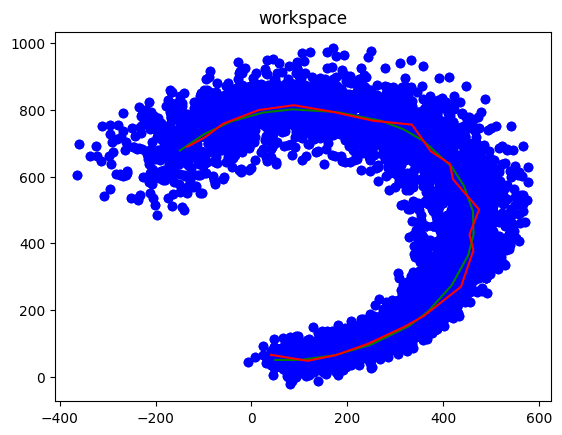

In [3]:
N = 20
pos_init =  np.array([50,50])
u = generate_moves(N)
r = generate_rots(N)

n_particles = 200
sigx = 30
sigy = 30
weights = np.ones(n_particles, dtype = np.float128) / n_particles

correct_robot  = robot(pos = pos_init, real = True)
pos_meas = correct_robot.measure()
initial_measure = np.array([pos_meas[0], pos_meas[1]])
particles = []
for i in range(n_particles):
    pos = initial_measure + np.array([np.random.normal(0,sigx), np.random.normal(0,sigy)])
    myrobot = robot(pos = pos, real = False)
    particles.append(myrobot)

plt.figure()
for i in range(N):
    correct_robot.move(u[i])
    correct_robot.measure()
    correct_robot.rot(r[i])
    x = []
    y = []
    for j in range(n_particles):
        rob = particles[j]
        rob.move(u[i])
        rob.rot(r[i])
        rob.show()
        xx,yy =rob.get()
        x.append(xx)
        y.append(yy)
    plt.scatter(x,y, c = 'b')



    
correct_robot.plot_coord()
correct_robot.plot_measure()

    

In [25]:
def prob( dist, meas_dist):
        d = np.sqrt(dist[0]**2+dist[1]**2)
        m = np.sqrt(meas_dist[0]**2+ meas_dist[1]**2)
        sig = 15*np.sqrt(2)
        #return 1/(2 * np.pi * robot.s_measure) *np.exp(-((d-m)**2 / (2.0 * robot.s_measure**2)))
        return 1/(2 * np.pi * sig) * np.exp( -((dist[0] - meas_dist[0])**2 / sig**2 +(dist[1] - meas_dist[1])**2 / sig**2))

def weight_calc(particles, weights, measure):
    n_particles = len(particles)
    for i in range(n_particles):
        weights[i] = prob(dist= particles[i].pos, meas_dist = np.array([measure[0], measure[1]]))
        
    weights = weights / np.sum(weights)
    for i in range(n_particles):
        particles[i].weight = weights[i]
    return weights

def resample(particles, weights):
    newParticles = []
    newWeights = []
    n = len(particles)
    index = np.random.randint(0, n)
    betta = 0
    s = set()
    for i in range(n):
        betta = betta + np.random.uniform(0, 2*np.max(weights))
        while betta > weights[index]:
            betta = betta - weights[index]
            index = (index + 1)%n # index changes in a loop from 0 to N
        s.add(particles[index])

    for el in s:
        newParticles.append(el)
        newWeights.append(el.weight)
    newWeights = np.array(newWeights)
    newWeights = newWeights / np.sum(newWeights)
    
    return newParticles, newWeights

def estimation(particles, weights):
    estimateX = np.array([0,0])
    for i in range(len(particles)):
        estimateX = estimateX + particles[i].pos * weights[i]
    return estimateX

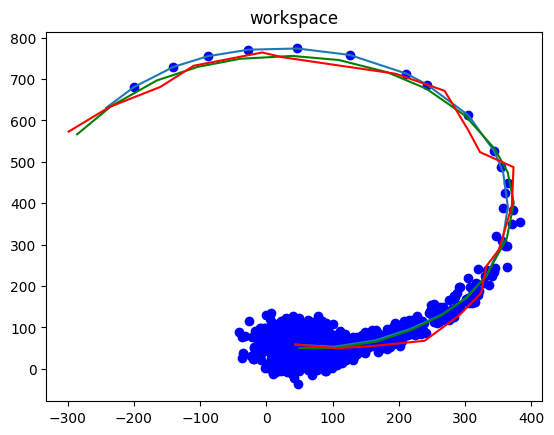

In [26]:
N = 20
pos_init =  np.array([50,50])
u = generate_moves(N)
r = generate_rots(N)

n_particles = 500
sigx = 30
sigy = 30
weights = np.ones(n_particles, dtype = np.float128) / n_particles

correct_robot  = robot(pos = pos_init, real = True)
pos_meas = correct_robot.measure()
initial_measure = np.array([pos_meas[0], pos_meas[1]])
particles = []
for i in range(n_particles):
    pos = initial_measure + np.array([np.random.normal(0,sigx), np.random.normal(0,sigy)])
    myrobot = robot(pos = pos, real = False)
    particles.append(myrobot)

estx = [initial_measure[0]]
esty = [initial_measure[1]]

x_all = []
y_all = []
plt.figure()
for i in range(N):
    xes = []
    yes = []
    for j in range(n_particles):
        rob = particles[j]
        x,y = rob.show()
        xes.append(x)
        yes.append(y)
    correct_robot.move(u[i])
    correct_robot.measure()
    pos_meas = correct_robot.pos
    correct_robot.rot(r[i])
    for j in range(n_particles):
        particles[j].move(u[i])
        particles[j].rot(r[i])

        
    weights = weight_calc(particles, weights, pos_meas)
    particles, weights = resample(particles, weights)
    n_particles = len(particles)
    estxy = estimation(particles, weights)
    estx.append(estxy[0])
    esty.append(estxy[1])
    x_all.append(xes)
    y_all.append(yes)


plt.plot(estx, esty)
correct_robot.plot_coord()
correct_robot.plot_measure()
